In [1]:
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit.optimization.applications.ising import max_cut, tsp
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua import aqua_globals
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.optimization.problems import QuadraticProgram

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

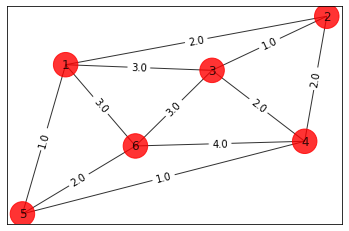

In [99]:
# Number of nodes in graph
n=6 
G=nx.Graph()
G.add_nodes_from(np.arange(1,n,1))
elist=[(1,2,2.0),(2,3,1.0),(3,4,2.0),(4,5,1.0),(5,6,2.0),(6,1,3.0),(1,3,3.0),(1,5,1.0),(2,4,2.0),(3,6,3.0),(4,6,4.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

In [100]:
pos

{1: array([-0.49817161,  0.41870036]),
 2: array([0.66131528, 0.87943779]),
 3: array([0.1520866 , 0.36508916]),
 4: array([ 0.56324687, -0.30938506]),
 5: array([-0.6900988, -1.       ]),
 6: array([-0.18837835, -0.35384224])}

In [101]:
colors

['r', 'r', 'r', 'r', 'r', 'r']

In [102]:
G

In [103]:
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight']
print(w)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 2. 3. 0. 1.]
 [0. 2. 0. 1. 2. 0.]
 [0. 3. 1. 0. 2. 0.]
 [0. 0. 2. 2. 0. 1.]
 [0. 1. 0. 0. 1. 0.]]


In [104]:
qubitOp, offset = max_cut.get_operator(w)
print('Offset:', offset)
print('Ising Hamiltonian:')
print(qubitOp.print_details())

Offset: -6.0
Ising Hamiltonian:
IIIZZI	(1+0j)
IIZIZI	(1.5+0j)
IIZZII	(0.5+0j)
IZIZII	(1+0j)
IZZIII	(1+0j)
ZIIIZI	(0.5+0j)
ZZIIII	(0.5+0j)



In [105]:
aqua_globals.random_seed = np.random.default_rng(123)
seed = 10598
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

In [106]:
# construct VQE
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa, quantum_instance=quantum_instance)


In [107]:
result = vqe.run(quantum_instance)


In [108]:
x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('time:', result.optimizer_time)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

energy: -4.965511711953637
time: 10.820916175842285
max-cut objective: -10.965511711953637
solution: [0. 1. 0. 0. 1. 0.]
solution objective: 11.0


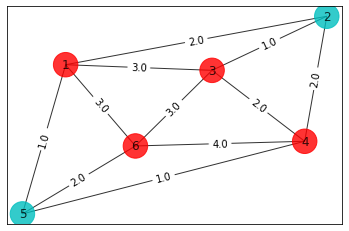

In [109]:
colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)

In [26]:
colors

['c', 'r', 'c', 'r']

In [27]:
x

array([0., 1., 0., 1.])

In [28]:
pos

{0: array([-0.46518275,  0.04045341]),
 1: array([-0.0869624, -1.       ]),
 2: array([ 0.46518275, -0.04045341]),
 3: array([0.0869624, 1.       ])}

In [29]:
print(G)

In [97]:
np.arange(0,6,1)

array([0, 1, 2, 3, 4, 5])

In [98]:
np.arange(0,n,1)

array([0, 1, 2, 3, 4, 5])